Step 1: Imports

Import packages for general use. io is specifically used to read in the image file. 

In [1]:
import numpy as np
import skimage as sk
from skimage import io

Import packages used for the image processing.

In [11]:
from skimage.color import rgb2gray
from skimage.util import pad, img_as_float, img_as_ubyte
from skimage.filters import rank
from skimage.morphology import square, disk, star
from skimage.morphology import opening as gs_opening
from skimage.morphology import closing as gs_closing

Import package used for blob detection. In this case there are three different funcions which could be used, here I use blob_doh which uses the derivative of the Hessian.

In [3]:
from skimage.feature import blob_dog, blob_log, blob_doh

Good old matplotlib for plotting!

In [4]:
import matplotlib.pyplot as plt

Step 2: Image Enchancement

This block of codes reads in the image of interest and plots it, so we can make sure that we are reading in the correct image! It also plots the inverse image to get a better idea of how "loud" the background dark drops are.

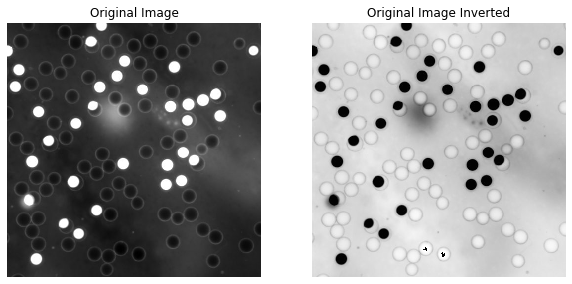

In [149]:
original = io.imread('test.jpg')
fig, axes = plt.subplots(ncols=2,figsize=(10,15))
for ax in axes:
    ax.axis('off')
axes[0].imshow(original, cmap='gray')
axes[0].title.set_text('Original Image')
axes[1].imshow(1-original, cmap='gray')
axes[1].title.set_text('Original Image Inverted')
plt.show()

As we can see here, the correct image has been loaded. We can also see in the inverted image that although the white blobs are quite distince, the dark blobs are causing a good amount of noise in the background as well. We also see two funny dark specs in the bottom. Unfortunately... can't remove them with a good spray of Windex...

Next, we convert the color image into grayscale. Although the image looks grayscale, it actually isn't. We might as well do a full conversion to make the later steps less computationally expensive. The image is also converted into byte format (alternatively img_as_float could be used, but this raises some warnings so img_as_ubyte is used instead).

In [150]:
grayscale = rgb2gray(original)
byte = img_as_ubyte(grayscale)

The first image processing step is an opening step. This helps to smooth out the dark blobs in the background. The main "noise" provided by the dark blobs is actually their outline! Doing a opening operation with a disk of size 5 does a good job of smoothing out the edges. We could do a larger disk to smooth things out even more, but then the white blobs start to become rather ill-defined. We can also see that the small black specs on the bottom have been well reduced in scale.

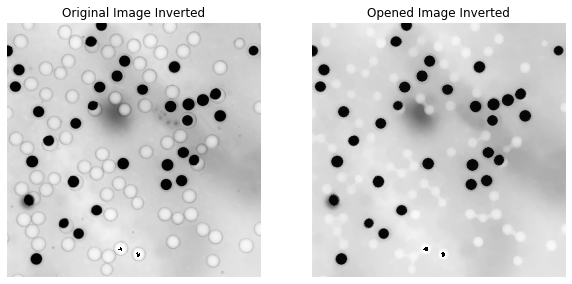

In [180]:
opened = gs_opening(byte, disk(7))
inverted = 1-opened
fig, axes = plt.subplots(ncols=2,figsize=(10,15))
for ax in axes:
    ax.axis('off')
axes[0].imshow(1-original, cmap='gray')
axes[0].title.set_text('Original Image Inverted')
axes[1].imshow(inverted, cmap='gray')
axes[1].title.set_text('Opened Image Inverted')
plt.show()

Now we will futher help the smoothing process by using some filters to blur the image just enough that the background becomes more of a uniform shade. However, we don't want to blur it too much because then we lose a significant amount of definition on our dark blobs. We want to know their radius as well as their count, so it's important to keep their shape to a certain point.

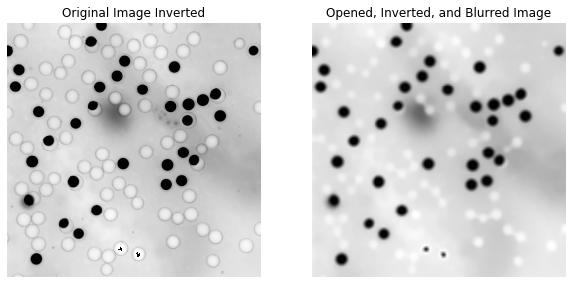

In [181]:
blurred = rank.mean(inverted,square(8))
fig, axes = plt.subplots(ncols=2,figsize=(10,15))
for ax in axes:
    ax.axis('off')
axes[0].imshow(1-original, cmap='gray')
axes[0].title.set_text('Original Image Inverted')
axes[1].imshow(blurred, cmap='gray')
axes[1].title.set_text('Opened, Inverted, and Blurred Image')

At this point we've done a very good job of separating out the light blobs and the dark blobs by "merging" the dark blobs with the background. Remember, the inverted images are the ones being plotted! Now we are going to attempt to remove everything in the image except the dark blobs by setting a threshold. To help choose the threshold, we will make a histogram of the intensities of the processed image (the one to the right in the above plot).

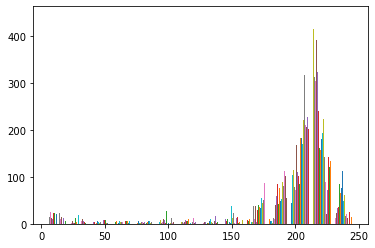

In [182]:
maximum=max(map(max,blurred))
minimum=min(map(min,blurred))
ordinal=np.linspace(minimum,maximum,15)
plt.hist(blurred,bins=ordinal)
plt.show()

We can see that there is a large collection of intensity values after about 140 to try and grab the darker splotches in the background. Because we know that the majority of the background is composed of higher intensity pixels, this makes sense. We can roughly set our threshold to 150 and set all pixels higher than this values to the same intensity.

In [183]:
clipped=blurred
for i in range(0,512):
    for j in range(0,512):
        if clipped[i][j] > 140:
            clipped[i][j] = 250

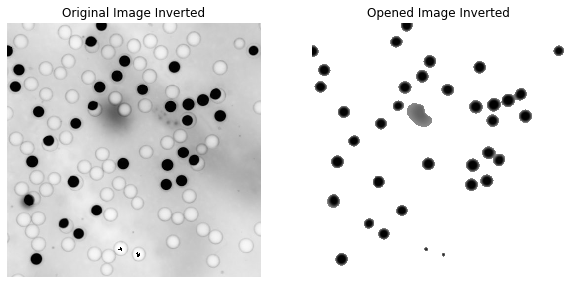

In [184]:
fig, axes = plt.subplots(ncols=2,figsize=(10,15))
for ax in axes:
    ax.axis('off')
axes[0].imshow(1-original, cmap='gray')
axes[0].title.set_text('Original Image Inverted')
axes[1].imshow(clipped, cmap='gray')
axes[1].title.set_text('Opened Image Inverted')
plt.show()

Well, that looks alright!

Step 3: Blob Detection on Enhanced Image

Finally, now we can try some actual edge dection? It seems like with everything in life, most of our time is spent in prepartion of a big event that turns out somewhat underwhleming.

In [189]:
manipulate = blob_doh(clipped,max_sigma=35,num_sigma=10,threshold=.01)

Step 4: Visualization of Results

Finally! It's time to maybe see some good results.

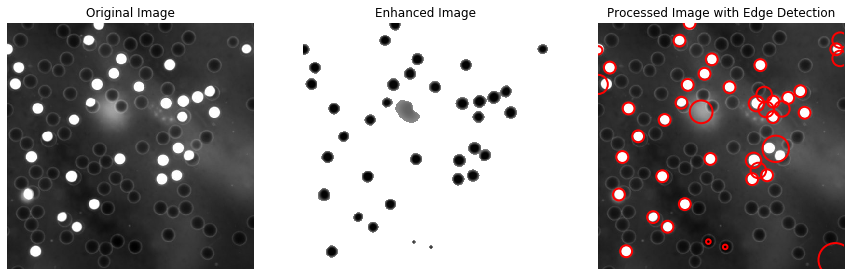

In [192]:
fig, ax = plt.subplots(ncols=3, figsize=(15, 5))
ax[0].imshow(original)
ax[0].set_title('Original Image')
ax[0].set_axis_off()
ax[1].imshow(clipped,cmap='gray')
ax[1].set_title('Enhanced Image')
ax[1].set_axis_off()
ax[2].imshow(original)
ax[2].set_title('Processed Image with Edge Detection')
ax[2].set_axis_off()

blob_list=[]
for blob in manipulate:
    y, x, r = blob
    c = plt.Circle((x, y), r, color='red', linewidth=2, fill=False)
    blob_list.append(r)
    ax[2].add_patch(c)
plt.show()

Admittedly not the best results, but at least it's something right?

There are a few places where the blob detection function seemingly saw some ghosts... However, it's clear that it did have issues with blobs that were too close together, the dark specs in the bottom center were too obvious as well as the lighting from the microscope near the center. Still time to count the number of blobs and get their sizes! The radius of the blobs is taken as the standard deviation of the Hessian in this case.

In [195]:
count=len(blob_list)
avg_rad=(sum(blob_list)/count)
avg_dia=2*avg_rad

In [197]:
print('The number of detected blobs is {}.'.format(count))
print('The average diameter of these blobs is {}.'.format(round(avg_dia,1)))

The number of detected blobs is 43.
The average diameter of these blobs is 27.8.


In [198]:
pwd

'/home/jovyan/Homeworks'